# Plot surface elevations and bed topography along the centerline

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import xarray as xr
import rioxarray as rxr
from matplotlib.cm import ScalarMappable
from tqdm.auto import tqdm

## Define paths in directory

In [2]:
# Path to Hubbard data for convenience
data_path = '/Users/raineyaberle/Research/Hubbard/'

# Where figure will be saved
figures_out_path = os.path.join(data_path, 'figures') 

# Bed topography
bed_fn = os.path.join(data_path, 'bed_topo', 'hubbard_bedrock_icebridge.tif')

# Centerline
cl_fn = os.path.join(data_path, 'velocity', 'center_50m.gpkg')

# Surface elevations
h_cl_fn = os.path.join(data_path, 'DEMs', 'centerline_surface_elevation_timeseries_smooth.csv')

## Load data

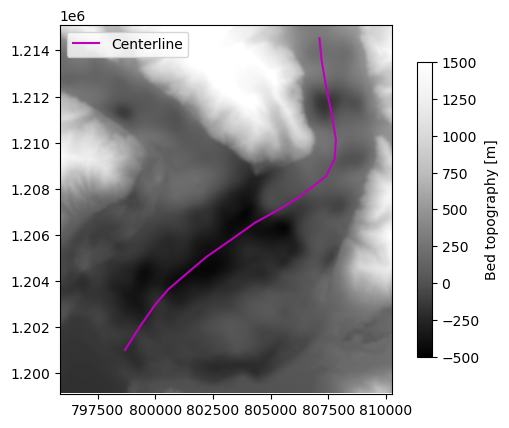

In [4]:
# Centerline
cl = gpd.read_file(cl_fn)
# calculate distance vector
def create_distance_vector(line):
    x, y = line.coords.xy[0], line.coords.xy[1]
    line_dist = np.zeros(len(line.coords.xy[0]))
    for i in range(1, len(line.coords.xy[0])):
        line_dist[i] = np.sqrt((x[i]-x[i-1])**2 + (y[i]-y[i-1])**2) + line_dist[i-1]
    return line_dist
cl_dist = create_distance_vector(cl.geometry[0])
# Flip to start near terminus
cl_dist = np.flip(cl_dist)

# Bed
bed = xr.open_dataset(bed_fn)
x_samp, y_samp = cl.geometry[0].coords.xy
bed_cl = [bed.sel(x=x, y=y, method='nearest').band_data.data[0] for x, y in list(zip(x_samp, y_samp))]

# Surface elevations along centerline
h_cl_df = pd.read_csv(h_cl_fn)
h_cl_df['Date'] = pd.to_datetime(h_cl_df['Date'])

# Plot bed and centerline map
fig, ax = plt.subplots()
bed_im = ax.imshow(bed.band_data.data[0], cmap='Greys_r', clim=(-0.5e3, 1.5e3),
                   extent=(np.min(bed.x.data), np.max(bed.x.data),
                           np.min(bed.y.data), np.max(bed.y.data)))
cl.plot(ax=ax, color='m', label='Centerline')
ax.legend(loc='upper left')
fig.colorbar(bed_im, shrink=0.8, label='Bed topography [m]')

plt.show()

## Plot surface elevation + bed

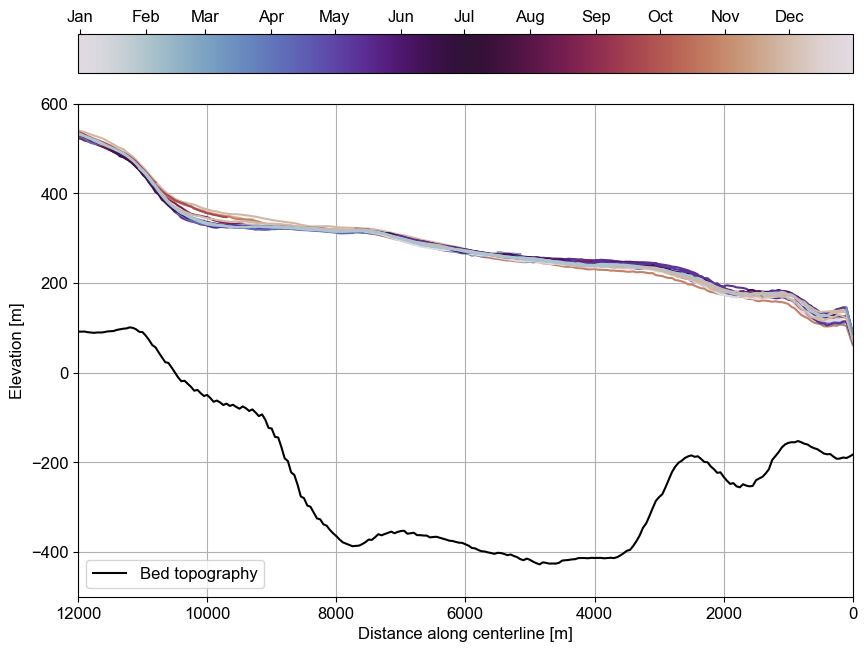

Figure saved to file: /Users/raineyaberle/Research/Hubbard/figures/centerline_surface_elevations_smooth.png


In [5]:
# Set up figure
plt.rcParams.update({'font.size':12, 'font.sans-serif':'Arial'})
fig, ax = plt.subplots(1, 1, figsize=(10,8))
lw=1.5

# Define colormap for surface profiles
cmap = plt.cm.twilight
# Plot surfaces
h_cols = [x for x in list(h_cl_df.columns) if '.0' in x]
for i in range(len(h_cl_df)):
    month = pd.DatetimeIndex(h_cl_df['Date']).month[i]
    color = cmap((month-1)/11)
    ax.plot(cl_dist, h_cl_df.iloc[i][h_cols], '-', linewidth=lw, color=color)
# Plot bed
x_samp, y_samp = cl.geometry[0].coords.xy
bed_cl = [bed.sel(x=x, y=y, method='nearest').band_data.data[0] for x, y in list(zip(x_samp, y_samp))]
ax.plot(cl_dist, bed_cl, '-k', linewidth=lw, label='Bed topography')
# Plot the colorbar
# Plot the colorbar
sm = ScalarMappable(cmap=cmap)
cbar = fig.colorbar(sm, ax=ax, location='top')
months = np.arange(1, 13)
labels = list(pd.to_datetime(months, format='%m').month_name().str.slice(stop=3))
ticks = [pd.DatetimeIndex([f'2017-0{month}-01']).dayofyear[0] / 365 if month < 10 
         else pd.DatetimeIndex([f'2017-{month}-01']).dayofyear[0] / 365 
         for month in months]
cbar.ax.set_xticks(ticks)
cbar.ax.set_xticklabels(labels)
# Adjust axes
ax.legend(loc='lower left')
ax.grid()
ax.set_xlabel('Distance along centerline [m]')
ax.set_ylabel('Elevation [m]')
ax.set_xlim(12e3, 0)
ax.set_ylim(-500, 600)

# Barcode plot of dates with elevation observations
# dts = pd.DatetimeIndex(dates)
# for dt in dts:
#     ax[2].plot([dt, dt], [0,1], '-k', linewidth=1)
# ax[2].set_yticks([])
# ax[2].set_xlim(np.datetime64('2009-01-01'), np.datetime64('2023-01-01'))
# ax[2].set_ylim(0,1)
# ax[2].set_title('Dates with surface observations')

plt.show()

# Save figure
fig_fn = os.path.join(figures_out_path, 'centerline_surface_elevations_smooth.png')
fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
print('Figure saved to file:', fig_fn)

## Plot surface elevation + bed + mean speed peak

In [6]:
# -----Calculate summer and winter speed speaks
# Load velocity
ds_fn = os.path.join(data_path, 'velocity', 'Hubbard_5eminus5.nc')
ds = xr.load_dataset(ds_fn)
ds["v"] = np.sqrt(ds.vx**2 + ds.vy**2).fillna(0)
ds["month"] = ds.time.dt.month
ds["year"] = ds.time.dt.year
ds["doy"] = ds.time.dt.dayofyear
ds = ds.rio.write_crs(rxr.open_rasterio(ds_fn).rio.crs)
ds = ds.rio.reproject('EPSG:3338')
ds = xr.where(ds > 1e10, np.nan, ds)


In [7]:
# Calculate strength of speed peaks
strengths_cl = pd.DataFrame()
years = [2016, 2017, 2018, 2019, 2020, 2021]
for year in tqdm(years):
    
    # Winter peak
    winter_mask = np.logical_or(
        np.logical_and(ds.month >= 11, ds.year == year),
        np.logical_and(ds.month <= 2, ds.year == year+1)
    )
    winter_velocities = ds.v[winter_mask, :, :]
    winter_peak = winter_velocities.max(dim='time')

    # Minimum between peaks
    middle_mask = np.logical_and(
        np.logical_and(ds.month >= 2.05, ds.month <= 4),
        ds.year == year+1,
    )
    middle_velocities = ds.v[middle_mask, :, :]
    min = middle_velocities.min(dim='time')

    # Summer peak
    summer_mask = np.logical_and(
        np.logical_and(ds.month >= 4, ds.month <= 6),
        ds.year == year+1,
    )
    summer_velocities = ds.v[summer_mask, :, :]
    summer_peak = summer_velocities.max(dim='time')

    # Calculate strength of double peaks 
    avg_mag = (winter_peak + summer_peak)/2
    mask = (winter_peak < min) | (summer_peak < 500)
    strength = (winter_peak - min) #/(summer_peak-min) # (winter_peak/summer_peak)
    strength = xr.where(mask==True, 0, strength)

    # Sample along centerline
    strength_cl_np = [float(strength.sel(x=x, y=y, method='nearest').data) for (x, y) in list(zip(x_samp, y_samp))]
    strength_cl = pd.DataFrame({year: strength_cl_np})

    # Smooth over a 500 m window
    strength_cl_smooth = strength_cl.rolling(10).mean()
    
    strengths_cl = pd.concat([strengths_cl, strength_cl_smooth], axis=1)

strengths_cl

  0%|          | 0/6 [00:00<?, ?it/s]

,2016,2017,2018,2019,2020,2021
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
354,388.143458,1292.183903,0.695948,1227.028540,988.690776,555.187588
355,377.203062,1253.897395,1.391897,1203.224470,1025.584511,535.533800
356,367.164582,1228.064690,1.391897,1159.095705,1087.889020,515.827748
357,357.126103,1202.231985,1.391897,1114.966940,1150.193529,496.121696


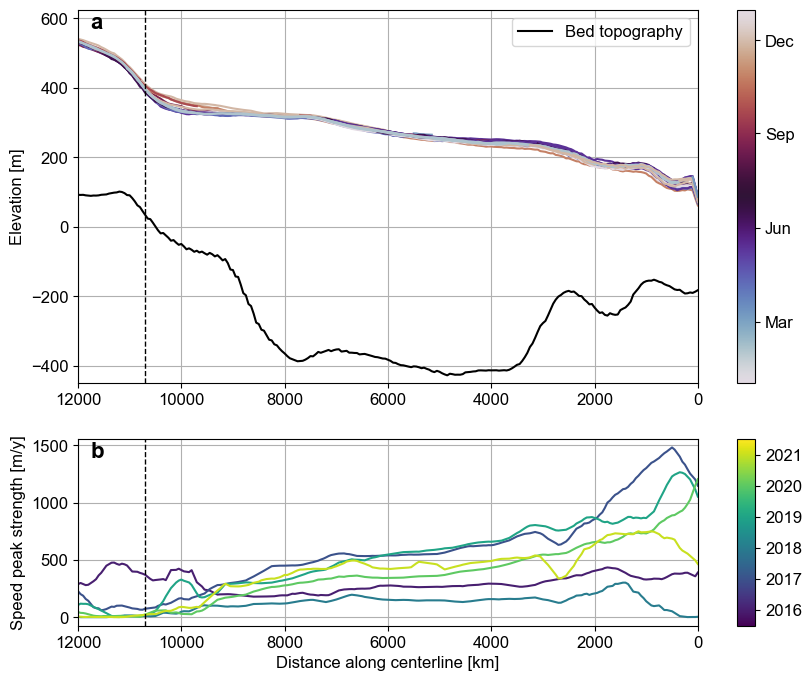

Figure saved to file: /Users/raineyaberle/Research/Hubbard/figures/centerline_surface_elevations_smooth_speed_strength.png


In [9]:
# Set up figure
fontsize=12
plt.rcParams.update({'font.size':fontsize, 'font.sans-serif':'Arial'})
fig, ax = plt.subplots(2, 1, figsize=(10,8), gridspec_kw={'height_ratios':[2, 1]})
lw=1.5
xlim = [12e3,0]

# Identify where the peak subsides in weaker speed years
weak_dist = 10.7e3

### a) Surface elevations + bed
# Define colormap for surface profiles
cmap = plt.cm.twilight
# Plot surfaces
h_cols = [x for x in list(h_cl_df.columns) if '.0' in x]
for i in range(len(h_cl_df)):
    month = pd.DatetimeIndex(h_cl_df['Date']).month[i]
    color = cmap((month-1)/11)
    ax[0].plot(cl_dist, h_cl_df.iloc[i][h_cols], '-', linewidth=lw, color=color)
# Plot bed
ax[0].plot(cl_dist, bed_cl, '-k', linewidth=lw, label='Bed topography')
# Plot the point where peak subsides
ax[0].axvline(weak_dist, color='k', linestyle='--', linewidth=1)
# Plot the colorbar
sm = ScalarMappable(cmap=cmap)
cbar = fig.colorbar(sm, ax=ax[0], location='right')
months = [3, 6, 9, 12]
labels = list(pd.to_datetime(months, format='%m').month_name().str.slice(stop=3))
ticks = [pd.DatetimeIndex([f'2017-0{month}-01']).dayofyear[0] / 365 if month < 10 
         else pd.DatetimeIndex([f'2017-{month}-01']).dayofyear[0] / 365 
         for month in months]
cbar.ax.set_yticks(ticks)
cbar.ax.set_yticklabels(labels)
# Adjust axes
ax[0].legend(loc='upper right')
ax[0].grid()
ax[0].set_ylabel('Elevation [m]')
ax[0].set_xlim(xlim)
ax[0].set_ylim(-450, 625)

### b) Speed strengths
cmap = plt.cm.viridis
for i, year in enumerate(years):
    ax[1].plot(cl_dist, strengths_cl[year], '-', color=cmap((i+0.5)/len(years)), label=year)
ax[1].set_xlim(xlim)
ax[1].set_yticks([0, 500, 1000, 1500])
ax[1].set_xlabel('Distance along centerline [km]')
ax[1].set_ylabel('Speed peak strength [m/y]')
ax[1].grid()
# Plot the point where peak subsides
ax[1].axvline(weak_dist, color='k', linestyle='--', linewidth=1)
# Plot colorbar
sm = ScalarMappable(cmap=cmap)
cbar = fig.colorbar(sm, ax=ax[1], location='right', aspect=10)
ticks = [(i+0.5)/len(years) for i in np.arange(0,len(years))]
labels = np.array(years).astype(str)
cbar.ax.set_yticks(ticks)
cbar.ax.set_yticklabels(labels)

### Add panel labels
labels = ['a', 'b']
for i, axis in enumerate(ax):
    if i==0:
        yscale = 0.95
    else:
        yscale = 0.9
    axis.text((axis.get_xlim()[1] - axis.get_xlim()[0]) * 0.02 + axis.get_xlim()[0], 
              (axis.get_ylim()[1] - axis.get_ylim()[0]) * yscale + axis.get_ylim()[0], 
              labels[i], fontweight='bold', fontsize=fontsize+4)
plt.show()

# Save figure
fig_fn = os.path.join(figures_out_path, 'centerline_surface_elevations_smooth_speed_strength.png')
fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
print('Figure saved to file:', fig_fn)